In [196]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [197]:
# Parámetros
sourceDataFolder = "1-source-data"

bumeraniterationNumber = "4"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

linkediniterationNumber = "2"
linkedinRootPath = sourceDataFolder + r"\main\linkedin\iteration-" + linkediniterationNumber

intermFilesFolder = "2-intermediate-files"
mergedMainFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [198]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [199]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-source-data\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta
    r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
    
  ]
  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [200]:
def getEncodingBumeran(file, stringLog):
  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [201]:
def getEncodingLinkedin(file, stringLog):
  encoding = "windows-1256"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1256") as f:
        if "charset=windows-1256" in f.read():
          encoding = 'windows-1256'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [202]:
def getCandidateBumeran(file, encoding, stringLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      # Nombre del postulante
      rawcandidateName = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[0].text # El split join tambien quita saltos de línea
      candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(rawcandidateName))

      # Pais de residencia
      tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")
      if len(tagResidenceCountry) > 2:
        if tagResidenceCountry[2].text.find(",") != -1:
          residenceCountry = parseNames(parseLineBreaksAndAccents(tagResidenceCountry[2].text[0:tagResidenceCountry[2].text.find(",")]))
          candidateData["residenceCountry"] = residenceCountry
          if residenceCountry == "":
            raise Exception("Error no mapeado 3")
        else:
          raise Exception("Error no mapeado 2")
      else:
        raise Exception("Error no mapeado 1 (posiblemente data incompleta como los 3 casos)")
      
      
      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)

      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[0].find_all("b")[0].text))
        candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[1].find_all("b")[0].text))

        daysOfExperience = 0
        for index in range(0, len(workExperienceTags), 2):
          startDate = datetime.datetime.strptime(parseLineBreaksAndAccents(workExperienceTags[index].text)[0: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")] , "%d-%m-%Y")
          endDateText = parseLineBreaksAndAccents(workExperienceTags[index].text)[parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")+3: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" | ")]
          endDate = datetime.datetime.strptime(endDateText, "%d-%m-%Y") if endDateText != "Presente" else datetime.datetime.strptime(rawPostulationDate, "%A, %B %d, %Y %I:%M %p")
          daysOfExperience = daysOfExperience + (endDate - startDate).days
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)

        if (candidateData["lastWorkCenter"] == "" or candidateData["lastWorkPosition"] == ""):
          raise Exception("Error no mapeado (experiencia laboral)")
      else:
        raise Exception("561 errores mapeados (experiencia laboral)")
      
      
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]
        
        careerTags0 = educationTags[0].find_all("b")
        candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
        candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))

        careerTags1 = educationTags[1].find_all("span")
        tempText = careerTags1[1].text
        #tempText = careerTags1[len(careerTags1)-2].text
        candidateData["careerStatus"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.find(",")+2:tempText.rfind(",")]))
        candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.rfind(",")+2:tempText.rfind(".")]))
        candidateData["studiesNumber"] = int(len(educationTags)/2)

        if (candidateData["studyCenter"] == "" or candidateData["careerField"] == "" or candidateData["careerStatus"] == "" or candidateData["careerDegree"] == ""):
          raise Exception("Error no mapeado (educación)")
      else:
        raise Exception("121 errores mapeados (educación)")

      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        technicalSkillsTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["technicalSkills"] = int(len(technicalSkillsTags)/4)
      else:
        raise Exception("Errores no mapeados (habilidades técnicas)")

      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        languagesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["languages"] = int(len(languagesTags)/7)
      else:
        raise Exception("Errores no mapeados (lenguajes)")

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        otherKnowledgesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["anotherSkills"] = int(len(otherKnowledgesTags)/3)
      else:
        raise Exception("Errores no mapeados (otras habilidades)")

      # Pendiente de analizar casos fraccionarios (se trunco para caso práctico)

      # Salario pretendido
      tagsSalary = [index for index, tag in enumerate(soup.find_all("span")) if "Sueldo pretendido" in tag.text]
      if len(tagsSalary) > 0:
        rawSalary = soup.find_all("span")[tagsSalary[0]+1].text
        candidateData["salary"] = int(rawSalary[rawSalary.find("$")+1:rawSalary.find(".")])
      else:
        raise Exception("Errores no mapeados (salario)")

  except Exception as e:
    candidateData = {}
    print(file)
    stringLog = stringLog + str(file) + "\n"
    traceback.print_exc()
    stringLog = stringLog + traceback.format_exc() + "\n"
    print()
    stringLog = stringLog + "\n"
    pass

  return candidateData, stringLog

In [203]:
def getCandidateLinkedin(file, encoding, stringLog):
  candidateData = {}

  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      
      soup = BeautifulSoup(myFile.read(), "lxml")

      spanBlack = soup.find_all("span", {"style": "color:black"})
      if len(spanBlack) > 4:
        postulationDate = datetime.datetime.strptime(spanBlack[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        postulationDate = datetime.datetime.strptime(spanBlack2[3].text, "%A, %B %d, %Y %I:%M %p")

      # Cambiar el lugar de donde se saca, sacarlo del body no del asunto
      if len(spanBlack) > 7:
        rawProfileName = parseLineBreaksAndAccents(spanBlack[7].text)
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawProfileName = parseLineBreaksAndAccents(spanBlack2[7].text)

      startIndexProfileName = rawProfileName.find(": ")
      endIndexProfileName = rawProfileName.find(" from ")

      if postulationDate <= datetime.datetime(2022,9,23,2,15,0):
        
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "font-size:10.5pt;color:#262626;text-decoration:none;\n            text-underline:none"}).text))

        tempSpanTags = soup.find_all("span", {"style": 'font-size:9.0pt;font-family:\n            "Helvetica",sans-serif;color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        notHaveScreening = True if "Screening qualifications" not in str(soup) else False
        startTag = 15 if notHaveScreening else 16
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Skills matching your job" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]

        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              #spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span") Caso particular que no vale la pena
              #startSpanIndex = 0 if len(spanTags) == 2 else len(spanTags)-3
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[1])
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTag = findedTableTags[haveTag].find_all("tr")[1]
              pTags = trTag.find_all("p")
              for pTag in pTags:
                spanTag = parseLineBreaksAndAccents(pTag.find_all("span")[1].text)
                startDate = datetime.datetime.strptime(spanTag.split(" - ")[0], "%Y")
                endDate = datetime.datetime.strptime(spanTag.split(" - ")[1], "%Y")
                daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(pTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if(len(trTag.find_all("span"))>1):
                  if(len(trTags[index-1].find_all("span")) == 1):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(len(trTag.find_all("span"))==1):
                  studiesNumber = studiesNumber + 1
              
              #print(firstCenterWithDateIndex)
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1])
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", "))
              #print(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1]))

              if firstCenterWithDateIndex != -1:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[1])) if len(tempTagArray) > 1 else ""
                candidateData["careerStatus"] = "En Curso" if ("Present" in parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[1].text)) else "Graduado"
                tempText = parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[0])
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText)) if not tempText[0:4].isnumeric() else ""
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          elif index == 3:
            if haveTag is not None:
              skillsCounter = 0
              spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span")
              for spanTag in spanTags:
                if "".join(spanTag["style"].split()) == 'font-size:10.5pt;font-family:"Helvetica",sans-serif;mso-fareast-font-family:"TimesNewRoman";color:#4D4D4D':
                  skillsCounter = skillsCounter + 1
              
              candidateData["technicalSkills"] = skillsCounter
            else:
              candidateData["technicalSkills"] = 0
            
            candidateData["languages"] = 1
            candidateData["anotherSkills"] = 0 if notHaveScreening else int(parseLineBreaksAndAccents(soup.find_all("table")[10].text)[parseLineBreaksAndAccents(soup.find_all("table")[10].text).find(": ")+2: parseLineBreaksAndAccents(soup.find_all("table")[10].text).find("/")])
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
        
      else:
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "color:#0A66C2;text-decoration:none;text-underline:none"}).text))
        
        tempSpanTags = soup.find_all("span", {"style": 'font-size:10.5pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        startTag = 14
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Screening qualifications" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]
        
        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              tempTrTags = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")
              #print(tempTrTags[1].find_all("span")[0].text)
              tempWorkCenter = tempTrTags[1] if len(tempTrTags) > 1 else ""
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(tempWorkCenter[0:tempWorkCenter.rfind(" - ")-4])) if tempWorkCenter != "" else ""
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTags = [x for x in findedTableTags[haveTag].find_all("tr") if x.find("span", {"style": 'font-size:9.0pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})]
              #print(trTags)
              for trTag in trTags:
                #print(pTag.text)
                spanTag = parseLineBreaksAndAccents(trTag.find_all("span")[0].text)
                #print(spanTag)
                #print("".isnumeric())
                if spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")].isnumeric() and spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7].isnumeric():
                  startDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")], "%Y")
                  endDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7], "%Y")
                  daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(trTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if " - " in parseLineBreaksAndAccents(trTag.text):
                  if " - " not in parseLineBreaksAndAccents(trTags[index-1].text):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(" - " not in parseLineBreaksAndAccents(trTag.text)):
                  studiesNumber = studiesNumber + 1
              #print(firstCenterWithDateIndex)
              if firstCenterWithDateIndex != -1:
                #print("GA")
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find("span").text))
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(tempTagArray[tempTagArray.find(", ")+1:tempTagArray.rfind(" - ")-4]))
                candidateData["careerStatus"] = "En Curso" if ("Present" in tempTagArray) else "Graduado"
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempTagArray[0:tempTagArray.find(", ")])) if tempTagArray.find(", ") != -1 else ""
                #print(candidateData)
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          
          elif index == 3:
            if haveTag is not None:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = int(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)[0])
            else:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = 0
            
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              #print(highlightText)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
      
  except Exception as e:
    candidateData = {}
    print(file)
    stringLog = stringLog + str(file) + "\n"
    traceback.print_exc()
    stringLog = stringLog + traceback.format_exc() + "\n"
    print()
    stringLog = stringLog + "\n"
    pass
  
  return candidateData, stringLog

In [204]:
def iterateFiles(files, source):
  # Definiendo el log de errores
  stringLog = ""

  # Definiendo la data final de candidatos
  data = []
  
  # Iterando por cada archivo
  for file in files:
    # Obteniendo el encoding por cada archivo
    encoding, stringLog = getEncodingBumeran(file, stringLog) if source == 'bumeran' else getEncodingLinkedin(file, stringLog)

    # Obteniendo los datos por cada archivo
    candidate, stringLog = getCandidateBumeran(file, encoding, stringLog) if source == 'bumeran' else getCandidateLinkedin(file, encoding, stringLog)
    
    # Añadiendo los datos del candidato a la data final
    if (candidate):
      data.append(candidate)

  return data, stringLog

In [205]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath if source == "bumeran" else linkedinRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Iterando sobre los archivos, calculando la data y el log de error
  data, stringLog = iterateFiles(files, source)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(stringLog, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [206]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [207]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  #columns = ["profileName", "residenceCountry"]
  #columns = ["lastWorkCenter", "lastWorkPosition", "yearsOfExperience", "worksNumber"]
  #columns = ["studyCenter", "careerField", "careerStatus", "careerDegree", "studiesNumber"]
  #columns = ["technicalSkills", "languages", "anotherSkills", "references", "salary"]
  columns = ["profileName", "residenceCountry", "lastWorkCenter", "lastWorkPosition", "yearsOfExperience", "worksNumber", "studyCenter", "careerField", "careerStatus", "careerDegree", "studiesNumber", "technicalSkills", "languages", "anotherSkills", "salary"]
  for column in columns:
    top10 = df[column].value_counts()[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-11 13:02:41.007877
Se inició el procesamiento
1-source-data\main\bumeran\iteration-4\2da-llamada\Has recibido un CV para el aviso _Arquitecto(a) Analytics_(1).html

1-source-data\main\bumeran\iteration-4\2da-llamada\Has recibido un CV para el aviso _Data Analyst Senior_.html

1-source-data\main\bumeran\iteration-4\2da-llamada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(2).html

1-source-data\main\bumeran\iteration-4\2da-llamada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(4).html

1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errore

1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Analista Programador . Net - SharePoint_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Analista Programador_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Data Engineer_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Desarrollador Sharepoint_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Trace

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(3).html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(4).html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_.html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(10).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(12).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Except

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(20).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(22).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(23).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(27).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(28).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(40).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(43).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(44).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(46).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(47).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de calidad Senior_(51).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(7).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Cal

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad.p_(1).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad.p_(3).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad.p_(8).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad.p_.html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(10).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(103).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(105).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(107).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(109).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(11).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(112).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(113).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(120).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(121).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(125).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(133).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(17).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(20).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habi

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(26).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(28).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(33).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(36).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(38).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(43).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(46).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(51).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(52).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(54).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(55).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(56).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(59).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(6).html

1-source-data\main\bumeran\iterat

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: 

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(65).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(66).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(67).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(72).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(73).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(79).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(82).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(83).html

1-source-data\main\bumeran\itera

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(88).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(91).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(92).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(94).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(96).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(97).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista Funcional QA Bilingüe_(1).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(1).html

1-source-data\main\bumeran\iter

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(17).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(19).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(2).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(22).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(24).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(26).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(28).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(29).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analist

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exce

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(38).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(4).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(47).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(48).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(52).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(56).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(57).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(59).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(61).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia la

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(8).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional Senior_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional Senior_(31).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional Senior_(32).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional Senior_(8).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(105).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(106).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(11).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(111).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(115).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Tra

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(120).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(134).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(137).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(142).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(144).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(147).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnica

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(163).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(165).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(166).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(18).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(19).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(3).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(40).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(43).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(47).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(48).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(57).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(6).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(62).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(64).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(71).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(73).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (sa

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(8).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(88).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(9).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(90).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(91).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(94).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(1).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(11).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(15).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(17).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(18).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(2).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(3).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(100).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(102).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(105).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(112).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(120).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(135).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(136).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(137).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(139).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(18).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(20).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(21).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(22).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: 

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(29).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(3).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(34).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(36).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(4).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(42).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: 

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(51).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(52).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(53).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(55).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no map

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(68).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(7).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(73).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(81).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(84).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)"

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(88).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _  Líder técnico _ Arquitecto Mobile_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _  Líder técnico _ Arquitecto Mobile_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _  Líder técnico _ Arquitecto Mobile_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _  Líder técnico _ Arquitecto Mobile_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _  Líder técnico _ Arquitecto Mobile_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _  Líder técnico _ Arquitecto Mobile_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _  Líder técnico _ Arquitecto Mobile_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(33).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most rece

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(56).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de calidad Senior_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de calidad Senior_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de calidad Senior_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.p_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.p_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.p_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.v_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.v_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.v_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.v_(3).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(caree

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.v_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.v_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)"

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Ciberseguridad_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no ma

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Ciberseguridad_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(3).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(44).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(11)

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Excep

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(22).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habi

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(43).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habili

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(55).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(56).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras h

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(64).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(70).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(76).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(79).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(86).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(89).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras h

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(53).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(55).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(64).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(68).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(72).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(76).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(80).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(84).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(87).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilid

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(37).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técn

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(45).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Funcional QA Bilingü

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Funcional QA Bilingüe_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador 

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - PWA_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - PWA_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - Xamarin_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador . Net - SharePoint_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador . NET_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador . NET_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Android_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Android_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Android_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Android_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otr

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Android_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Java Jr_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Net Core_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Net Core_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Net Core_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Net Core_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Net Core_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Oracle Forms_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Oracle Forms_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Oracle Forms_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Oracle Forms_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador PHP_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador PHP_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador PHP_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador PHP_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador PHP_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso 

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent cal

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador _(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador _(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador _(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador _(7).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras h

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(101).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(104).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(105).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(106).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(109).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(113).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(115).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(116).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(117).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(118).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(121).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(122).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(123).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(126).html

1-source-data\main\bumer

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otr

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(130).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(132).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(135).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(138).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(139).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(143).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(144).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(146).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(147).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(157).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(167).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(169).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(174).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(175).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(177).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(178).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(179).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(181).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(182).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(185).html

1-source-data\main\bumer

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras h

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(192).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(196).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(198).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(199).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(200).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(201).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras h

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(205).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(210).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(211).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(212).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(215).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(218).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técn

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(220).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(221).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(223).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(224).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(228).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(233).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(234).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(235).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(237).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(238).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(37).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(50).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(56).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapea

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(64).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(77).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(82).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(84).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(88).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(91).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(93).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(94).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(95).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(96).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(97).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(98).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Desarrollo_(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (m

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Desarrollo_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Software_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Software_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Software_(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Software_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Software_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Software_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Software_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Soluciones_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Soluciones_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto(a) Analytics_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(12).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(24).html

1-source-data\mai

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(50).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
E

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(68).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(7).html

1-source-data\mai

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(79).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(88).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(92).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of ra

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(100).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(101).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(104).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(106).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(107).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(108).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(111).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(120).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(121).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(124).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(125).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(128).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(129).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(135).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(143).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(145).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(146).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(147).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(152).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(153).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el av

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exceptio

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(158).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(164).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(167).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(168).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(171).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(172).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(176).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(185).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(187).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(190).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(196).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(197).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el avi

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(204).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(206).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(209).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(210).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Excep

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(218).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(221).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(226).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)"

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(233).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(234).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(236).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(237).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(247).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(248).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(251).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(255).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(258).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(269).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(275).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(276).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(280).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(283).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(291).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(298).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(299).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(301).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(302).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no m

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(313).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(318).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(320).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(321).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(324).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(325).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(326).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilid

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(332).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(334).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(336).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(338).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Excep

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(50).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(55).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _A

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(64).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(74).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(77).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no m

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(81).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(82).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(85).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(86).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(92).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _As

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistent

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilid

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(51).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no ma

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(71).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(24).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(33).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Automatizador de Procesos_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Automatizador de Procesos_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Automatizador de Procesos_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Automatizador de Procesos_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido 

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no m

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(3).html

1-source-data\main\bumeran\i

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (ot

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(55).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(56).html

1-source-data\main\bumeran\i

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Except

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(71).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(79).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(81).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_.html

1-source-data\main\bumeran\iterat

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Except

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(26).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(40).html

1-source-data\main\bumeran\iterati

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exc

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps - Azure_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps - Azure_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps - Azure_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Clou

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps _(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps _(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps_(8).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exce

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(28).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(45).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(60).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - MS Azure_(64).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - MS Azure_(69).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - MS Azure_(71).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist Jr. - MS Azure_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist Jr. - MS Azure_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist Jr. - MS Azure_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist Jr. - MS Azure_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist Jr. - MS Azure_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist SemiSenior - MS Azure_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist SemiSenior - MS Azure_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist SemiSenior - MS Azure_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist SemiSenior - MS Azure_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist SemiSenior - MS Azure_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist SemiSenior - MS Azure_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(100).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(102).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(104).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(109).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lengu

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(116).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(117).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(120).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(29).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(36).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(48).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(62).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no m

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(70).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(90).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mape

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Preventa _ Arquitecto Azure_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor(a) Infrastructure & Cloud Services_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Analyst Senior_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Analyst Senior_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer Sr._(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer Sr._(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer Sr._(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades téc

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer Sr._(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer Sr._(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(20).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET - CRM_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET - CRM_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET - CRM_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET - CRM_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET - CRM_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET - CRM_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(100).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(104).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(106).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(113).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(114).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (ot

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(120).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(126).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(129).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(131).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(132).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(136).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(137).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(140).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(151).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(153).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(154).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(156).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(160).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(166).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(169).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-en

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exceptio

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(52).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-e

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapead

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(68).html

1-source-data\main\bumeran\iteration-4\bandeja-en

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(76).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(77).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(83).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(91).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(93).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(94).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(95).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(96).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(98).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(12).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otr

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(6).h

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(21).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapea

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Full Stack_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador FullStack_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador FullStack_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador FullStack_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(28).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-e

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educ

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(68).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(70).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(74).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades téc

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(76).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(77).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador PHP_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador PHP_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador PHP_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
Index

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador PHP_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador PHP_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador PHP_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Python (Temporal)_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].t

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Sharepoint_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has r

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Ha

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia labor

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(33).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores map

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el av

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapea

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(50).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(52).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no ma

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exce

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\H

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(80).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(83).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(101).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(102).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(105).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(107).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(110).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(113).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(114).html

1-source-data\main\bumeran\iterat

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(122).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(123).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(124).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(127).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: E

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(136).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(139).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(140).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(141).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(147).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(151).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras h

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(155).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(156).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(160).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(161).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(163).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(165).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(168).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(170).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exce

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(177).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(178).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(179).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(180).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(181).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(186).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(187).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(19).html

1-source-data\main\bumeran\iterat

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(204).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(205).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(206).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(209).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(210).html

1-source-data\main\bumeran\iteration

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(220).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(223).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(224).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(227).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(232).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(234).html

1-source-data\main\bumeran\iterati

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilid

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(241).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(245).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(246).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(255).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(260).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(261).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(263).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(265).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(269).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(271).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(272).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(275).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(279).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(28).html

1-source-data\main\bumeran\iterat

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(282).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(283).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(285).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(286).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(290).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(292).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(297).html

1-source-data\main\bumeran\iterat

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(303).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(305).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(307).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(311).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(319).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(320).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)"

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(324).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(326).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(328).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(329).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(331).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(332).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(36).html

1-source-data\main\bumeran\iterati

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(59).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(70).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(72).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(74).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(8).html

1-source-data\main\bumeran\iteration-4\ban

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(88).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(91).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(92).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(93).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(98).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_.html

1-source-data\main\bumeran\iteration-4\bandej

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otr

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el av

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(104).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(106).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(107).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no map

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(111).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(113).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(115).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(117).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(118).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(119).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(122).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(134).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(138).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(141).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(143).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(146).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(148).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial 

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otr

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(34)

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(48)

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (ot

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(68).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(70).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(72)

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(82).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(84).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(86).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(92).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(93).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(94

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(26).html

1-source-data\ma

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(11).html

1-source-data\mai

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(34).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
Index

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(48

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recen

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - CRM_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - CRM_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - CRM_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - CRM_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - CRM_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(11).html


Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(25).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilid

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net Jr._(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(100).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(101).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(120).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(33).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent ca

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(50).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(52).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(56).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(68).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(69).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(70).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(80).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(81).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(83).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(84).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(91).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(93).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ro

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(99).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(24).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(32).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Junior_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Junior_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(39).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cyberseguridad_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cyberseguridad_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cyberseguridad_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cyberseguridad_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Desarrollador de Software_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Desarrollador de Software_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Desarrollador de Software_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Desarrollador de Software_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido 

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Devops_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Devops_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Devops_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Dynamics 365 Business Central_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Dynamics 365 Business Central_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Dynamics GP - Business Central_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el av

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(34).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 85, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores n

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(51).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 95, in getCandidateBumeran
    raise Exception("Error no mapeado (educación)")
Exception: Error no mapeado (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 85, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(56).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(68).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(71).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(74).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – I

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(81).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(22).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(43).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(57).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Inteligencia Artificial_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Inteligencia Artificial_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Inteligencia Artificial_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Inteligencia Artificial_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exce

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Inteligencia Artificial_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Inteligencia Artificial_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Office 365_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Office 365_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Power Platform _(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Power Platform _.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Project Server y Project Online_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Project Server y Project Online_(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365 - SharePoint_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365 - SharePoint_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365 - SharePoint_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(34).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(51).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(73).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(74).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(76).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Power BI_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Power BI_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Project  Online_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Project  Online_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Project  Online_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Project  Online_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Project  Online_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Project  Online_(37).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Senior en Datos_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Senior en Datos_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Sharepoint_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gerente de Línea - Modern WorkPlace_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gerente de Línea - Modern WorkPlace_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Licenciamiento_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Licenciamiento_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Licenciamiento_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(107).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(116).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(121).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(127).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(131).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 95, in getCandidateBumeran
    raise Exception("Error no mapeado (educación)")
Exception: Error no mapea

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(145).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(148).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(152).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(153).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(155).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(156).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(157).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(159).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(161).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(167).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(169).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(181).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(184).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(188).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(195).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(20).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(203).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(206).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(211).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(212).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(213).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(215).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(218).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exce

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(219).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(22).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(228).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(244).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(256).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(259).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(260).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(261).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(276).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(284).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(289).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(290).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(292).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(293).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(295).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(302).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(303).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(304).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapea

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(308).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(313).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(323).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(324).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(326).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(330).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(339).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(345).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(352).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(50).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otr

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(69).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(72).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(74).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(79).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(91).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(98).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(107).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(112).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(114).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(123).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(126).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(127).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(133).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(148).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(158).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(159).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recen

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(169).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(176).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(181).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(185).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(195).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(205).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(227).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(36).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no ma

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(52).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(58).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(65).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(74).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(86).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(99).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Modern WorkPlace_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Modern WorkPlace_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Modern WorkPlace_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Modern WorkPlace_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Modern WorkPlace_(3).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Modern WorkPlace_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(20).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(26).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(47).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(66).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(76).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(84).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(88).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores n

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(26).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Excep

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(52).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico de Big Data_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico de Big Data_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(100).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(101).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(102).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(122).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(124).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(132).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(134).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(136).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(137).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(141).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(142).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(143).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(146).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapea

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(33).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(45).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(55).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(63).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(71).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(73).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(83).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(84).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otr

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(86).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(96).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(98).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(50).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(51).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(66).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(74).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(77).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(80).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(84).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(85).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(87).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(1).html

1-source-data\main\bumeran\ite

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exce

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(23).html

1-source-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no ma

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(5).html

1-source-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Except

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Servicios TI_(1).html

1-source-da

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante Desarrollador .Net _ Sharepoint_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante Desarrollador .Net _ Sharepoint_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante Desarrollador .Net _ Sharepoint_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante Desarrollador .Net _ Sharepoint_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante Desarrollador .Net _ Sharepoint_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante Desarrollador .Net _ Sharepoint_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(10).html

1-source-data\main\b

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-en

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Excepti

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-en

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
E

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(71).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(72).html

1-source-data\main\bumeran\iteration-4\bandeja-ent

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia l

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(77).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(82).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(88).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(94).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(96).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Pre-Venta – Cloud Computing_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Pre-Venta – Cloud Computing_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapea

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Pre-Venta – Cloud Computing_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Pre-Venta – Cloud Computing_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd Java_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd Java_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(15).html

1-source-data\main\

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mape

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
E

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(21).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnica

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _QA FUNCIONAL - Aseguramiento de Calidad_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _QA FUNCIONAL - Aseguramiento de Calidad_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _QA FUNCIONAL - Aseguramiento de Calidad_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(36).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(60).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
E

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(69).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(76).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Senior Data Engineer_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Software Engineer_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Software Engineer_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errore

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(33).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (ot

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(52).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(60).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(70).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Technical Architect_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Technical Architect_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Technical Architect_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Technical Architect_(4).html

1-source-data\main\bumeran\iteration-4\ba

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(102).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(104).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(105).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(106).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(107).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(109).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(111).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 85, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(123).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(125).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(126).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(127).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(128).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(129).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(142).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(143).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(144).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(146).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(149).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(151).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recen

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(163).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(164).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(166).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(167).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(169).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(170).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(172).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mape

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(179).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(180).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(182).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(183).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(184).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(190).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(192).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 85, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (h

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(198).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(205).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(206).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(211).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(212).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(215).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(216).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(217).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(218).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(219).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(220).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(222).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(236).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(237).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(238).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(240).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(241).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(242).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(254).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(256).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(257).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(258).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(259).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(263).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-a

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(275).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(276).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(278).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(279).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(280).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(283).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(285).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asisten

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(52).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(55).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asisten

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mape

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(68).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(69).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(70).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(72).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistent

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilid

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(86).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(90).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(91).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(93).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(97).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-communit

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilid

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(108).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(109).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(110).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(112).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(113).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(118).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(12).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Err

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(121).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(124).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(125).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(126).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(127).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(131).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(132).html

1-source-data\main\bumeran\iteration-4\bandeja-e

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(141).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(143).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(146).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(147).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(150).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(155).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)"

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(160).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(161).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(162).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(164).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(170).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(171).html

1-source-data\main\bumeran\iteration-4\bandeja-en

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(183).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(186).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most re

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-c

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no m

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(55).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(57).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(77).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(79).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(80).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(81).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(85).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(97).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(98).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(99).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-proc

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(53).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Excep

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(64).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-e

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exc

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-seguridad-aplicaciones\Has recibido un CV para el aviso _Especialista de Seguridad de Aplicaciones_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-seguridad-aplicaciones\Has recibido un CV para el aviso _Especialista de Seguridad de Aplicaciones_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-seguridad-aplicaciones\Has recibido un CV para el aviso _Especialista de Seguridad de Aplicaciones_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-seguridad-aplicaciones\Has recibido un CV para el 

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")


1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Adm

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (expe

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(32).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(51).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(9).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud Senior_(3).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(11).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(14).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(16).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Except

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(2).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(21).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(9).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Especialista Cloud_.html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educa

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(15).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(19).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(2).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(21).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(24).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(25).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Trace

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(28).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(29).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(32).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(33).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(37).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lengu

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(40).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(46).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(47).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(8).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial - Sector TI_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Except

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial - Sector TI_(4).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial - Sector TI_(7).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial - Sector TI_(8).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(1).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(11).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(12).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(13).html

1-source-data\main\bumeran\itera

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia lab

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(22).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(25).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(26).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(27).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(29).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(3).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(32).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(33).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(34).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(36).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(41).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(45).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(46).html

1-source-data

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(54).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(56).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(57).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(59).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(60).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(61).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(62).html

1-source-data

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(76).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(77).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(81).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(83).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(84).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(85).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(86).html

1-source-data

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exce

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(100).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(108).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(11).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(110).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(116).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(12).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(120).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(14).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(17).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(20).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(23).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(26).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(30).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(4).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(40).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(43).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(46).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(48).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(49).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(50).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(54).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(55).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(58).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(6).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(61).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Co

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores n

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(70).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(75).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(76).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(77).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(78).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(79).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(84).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo C

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(90).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(93).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(95).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(96).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(98).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(99).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(1).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Com

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(20).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(23).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(25).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(26).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(27).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(3).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(30).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(39).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(4).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(41).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(42).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(6).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(7).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(8).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(15).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(16).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(20).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(21).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(22).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(23).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(24).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercia

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(34).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(36).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(37).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(39).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(4).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(42).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 95, in getCandidateBumeran
    raise Exception("Error no mapeado (educación)")
Exception: Error no mapea

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(53).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(54).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(55).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(6).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(60).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(62).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(63).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(70).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(71).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(72).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(78).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(79).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(8).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(81).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(9).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(1).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(100).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(102).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(109).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(13).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(14).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errore

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(2).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(20).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(28).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(29).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(35).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(39).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(41).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(44).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(45).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(46).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(47).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(48).html

1-source

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exce

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(54).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(55).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(56).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(57).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(6).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(60).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(61).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(62).html

1-source-

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados 

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(75).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(76).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(78).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(8).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(82).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(83).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no m

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(96).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(98).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(99).html

1-source-data\main\bumeran\iteration-4\especialista-cloud\Has recibido un CV para el aviso _Especialista Cloud_(1).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(1).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(13).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(15).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)


1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(5).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(7).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._.html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud_(7).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(10).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(11).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(12).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(2).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (o

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(1).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(10).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(2).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(5).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(9).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_.html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exc

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(22).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(25).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(36).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(44).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(54).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(58).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(60).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(62).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(63).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
E

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(102).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(112).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(118).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(12).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(120).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(123).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(132).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(14).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(16).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidad

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(20).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(21).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(23).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(24).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(25).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(3).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analy

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores n

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(35).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(45).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(46).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(49).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(53).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(54).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(60).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(68).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(69).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(72).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(73).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(77).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(78).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
E

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(85).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(88).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(92).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(93).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(95).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1]

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(10).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(100).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(11).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception:

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(21).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(22).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(23).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(24).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(27).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(29).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(32).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(33).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 85, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBr

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(51).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(54).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(58).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(6).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(68).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(75).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(76).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(77).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeado

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(83).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(96).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(10).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(21).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(22).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(25).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(46).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(50).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(7).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(8).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(9).html

1-source-data\main\bumeran\iteration-4\power-platform\Has recibido un CV para el aviso _Especialista Power Platform_(1).html

1-source-data\main\bumeran\iteration-4\power-platform\Has recibido un CV para el aviso _Especialista Power Platform_(11).html

1-source-data\main\bumeran\iteration-4\power-platform\Has recibido un CV para el aviso _Especialista Power Platform_(2).html

1-source-data\main\bumeran\iteration-4\power-platform\Has recibido un CV para el aviso _Especialista Power Platform_(3).html

1-source-data\main\bumeran\iteration-4\power-platform\Has recibido un CV para el aviso _Especialist

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(101).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(103).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(105).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(107).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(11).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(110).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")


1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(116).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(12).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(121).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(122).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(123).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(124).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Er

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(130).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(131).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(132).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(133).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(134).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(135).html

1-source-data\main\bumeran\iteration-4\practicante-infraes

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades téc

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(15).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(150).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(153).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(154).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(155).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(156).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(172).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(173).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(175).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(176).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(178).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(179).html

1-source-data\main\bumeran\iteration-4\practicante-infraes

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exce

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(187).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(188).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(189).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(19).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(191).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(192).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errore

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(207).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(208).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(21).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(210).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(211).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(214).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Except

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(33).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(34).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(35).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(36).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(37).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(38).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructu

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapea

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(52).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(53).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(54).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(55).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(56).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(57).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructu

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")


1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(73).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(75).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(76).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(77).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(79).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(8).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructur

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exce

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(9).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(92).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(93).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(94).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(95).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(96).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructur

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(102).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(107).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(109).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(11).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(110).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras h

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(113).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(115).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(12).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(122).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(123).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(13).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(14).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(15).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(16).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(17).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(21).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(24).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(25

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(33).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(38).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(4).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(42).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapea

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(44).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(47).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(49).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(54).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(57).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(60).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(65).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(66).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(69).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(7).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(73).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(77).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(79).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(8).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(80).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(81).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(82).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(83).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(85).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(86).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(88).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(89).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(9).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(90)

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(92).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(95).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(98).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(3).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 er

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(6).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(1).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(10).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(102).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(103).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(106).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(109).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(11).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(110).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(111).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(114).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(118).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(119).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(12).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(120).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(121).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(122).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(123).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(124).html

1-source-data\main\bumeran\iteration-4\programador-net\Ha

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(131).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(132).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(136).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(137).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(144).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(154).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(157).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(158).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(159).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(162).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(165).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(168).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(169).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(17).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(172).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(173).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(174).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(175).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Tra

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(18).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(182).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(185).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(187).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(188).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Error

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(19).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(194).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(196).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(198).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(2).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(200).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list i

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(203).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(205).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(210).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(212).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(213).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(214).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(217).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(219).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(225).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(227).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(228).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(23).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(230).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(238).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(24).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(240).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(241).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(245).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(246).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(25).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(27).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(28).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(30).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(31).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(32).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(33).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(34).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(35).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(36).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(41).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(42).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapead

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(44).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(45).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(46).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(50).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(53).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(54).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(55).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(57).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(61).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(63).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(64).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(65).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(69).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(7).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(74).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(76).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(77).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(78).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(8).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(84).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilida

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(85).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(87).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(9).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(90).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(91).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(92).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(93).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(95).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibi

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia l

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(99).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(1).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(10).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(101).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(103).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(104).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(105).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Excepti

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(119).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(12).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(120).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(121).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(122).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(123).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(125).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 5

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(138).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(14).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(140).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(141).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(143).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(144).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(145).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errore

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(159).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(16).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(160).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(161).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(162).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(163).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(164).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Except

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(183).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(184).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(185).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(187).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(188).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(189).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(19).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(195).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(196).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(2).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(20).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(200).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(201).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(202).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recib

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
E

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(218).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(219).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(22).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(221).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(222).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(223).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(224).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(241).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(244).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(245).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(246).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(248).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(25).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(251).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exce

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(263).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(264).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(265).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(266).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(267).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(268).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(269).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mape

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(287).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(288).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(289).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(290).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(292).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(293).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(297).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (leng

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(308).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(309).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(31).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(312).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(314).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(315).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(316).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Excep

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(323).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(325).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(326).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(328).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(329).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(330).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(331).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(343).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(346).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(349).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(350).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(351).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(353).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(355).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
E

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(365).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(366).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(367).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(368).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(369).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(37).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(373).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mape

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(386).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(387).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(388).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(39).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(390).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(391).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(394).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(405).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(408).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(41).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(410).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(412).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(414).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(415).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)"

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(424).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(427).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(428).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(429).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(43).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(431).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(433).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Excep

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(446).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(448).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(449).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(450).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(455).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(456).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(458).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
E

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(466).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(467).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(468).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(469).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(471).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(473).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(475).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent c

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(486).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(489).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(490).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(491).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(492).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(493).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(494).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no ma

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(508).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(509).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(51).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(510).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(512).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(514).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(515).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")


1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(529).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(53).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(533).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(534).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(537).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(539).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(54).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has reci

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (l

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(550).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(551).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(552).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(555).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(557).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(559).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(560).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 45, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(571).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(573).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(576).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(577).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(578).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(58).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(580).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(596).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(599).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(6).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(60).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(601).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(603).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(604).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recib

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(610).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(613).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(614).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(616).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(617).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(618).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(62).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 97, in getCandidateBumeran
    raise Exception("121 errores mapeados (educación)")
Exception: 121 errores mapeados (educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index o

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(634).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(635).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(638).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(64).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(640).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(641).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(642).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Err

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(658).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(659).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(660).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(661).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(662).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(663).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(664).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Ex

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(68).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(680).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(685).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(689).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(69).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(690).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(691).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has reci

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(7).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(70).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(702).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(703).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(704).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(705).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(709).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recib

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exceptio

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(722).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(726).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(729).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(73).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(731).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(732).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(733).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(741).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(742).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(745).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(747).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(748).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(749).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(75).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: Errores no mapeados (lenguajes)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errore

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(764).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(766).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(767).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(769).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(77).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(771).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(772).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(79).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(790).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(791).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(795).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(796).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(797).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(798).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Excep

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(81).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(810).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(811).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(813).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(816).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(82).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(824).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has reci

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Er

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(831).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(832).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(833).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(834).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(835).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(837).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(84).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exceptio

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(858).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(86).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(862).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(863).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(864).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(866).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(868).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exceptio

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(881).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(884).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(889).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(893).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(894).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(895).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(896).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
E

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(899).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(9).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(90).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(901).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(903).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(904).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(905).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recib

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 5

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(924).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(925).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(926).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(927).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(93).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(934).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(935).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 86, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(948).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(949).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(95).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(96).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(97).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(99).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_.html

1-source-data\main\bumeran\iteration-4\sharepoint\Has recibido un CV pa

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 5

1-source-data\main\bumeran\iteration-4\sharepoint\Has recibido un CV para el aviso _Especialista Sharepoint_(8).html

1-source-data\main\bumeran\iteration-4\sharepoint\Has recibido un CV para el aviso _Especialista Sharepoint_.html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(12).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(13).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(14).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(15).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Error

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(26).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(33).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(34).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(35).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)"

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(40).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(43).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(45).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(47).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(5).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(6).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(7).html

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un C

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 138, in getCandidateBumeran
    raise Exception("Errores no mapeados (salario)")
Exception: Errores no mapeados (salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapea

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(11).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(12).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(15).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(16).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(18).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(19).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(2).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(20).html

1-source-data\mai

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Exception: Errores no mapeados (otras habilidades)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 128, in getCandidateBumeran
    raise Exception("Errores no mapeados (otras habilidades)")
Excepti

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(5).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(6).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(8).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(9).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_.html

Se terminó de procesar Bumeran
Se terminó de procesar Linkedin


Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 108, in getCandidateBumeran
    raise Exception("Errores no mapeados (habilidades técnicas)")
Exception: Errores no mapeados (habilidades técnicas)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 75, in getCandidateBumeran
    raise Exception("561 errores mapeados (experiencia laboral)")
Exception: 561 errores mapeados (experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\1988251658.py", line 118, in getCandidateBumeran
    raise Exception("Errores no mapeados (lenguajes)")
Exception: 

Se terminó de unir la data principal
postulationDate      6214
profileName          6214
candidateName        6214
residenceCountry     6214
lastWorkCenter       6214
lastWorkPosition     6214
yearsOfExperience    6214
worksNumber          6214
studyCenter          6214
careerField          6214
careerStatus         6214
careerDegree         6214
studiesNumber        6214
technicalSkills      6214
languages            6214
anotherSkills        6214
salary               6214
dtype: int64
Practicante De Recursos Humanos                    360
Gestor De Servicios De Ti                          288
Ejecutivo Comercial                                268
Jefe De Proyecto - Analytics & Ai                  252
Asistente De Recursos Humanos                      228
Analista Programador                               157
Programador .Net                                   140
Analista Funcional                                 135
Asistente Social                                   130
Analista De C

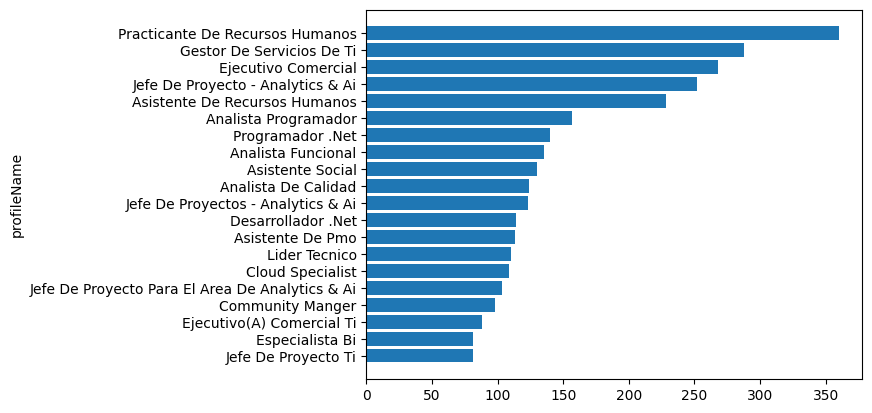

Peru                    6083
Venezuela                109
Argentina                  9
Brasil                     3
Colombia                   3
Ecuador                    2
Republica Dominicana       1
Francia                    1
Bolivia                    1
Panama                     1
El Salvador                1
Name: residenceCountry, dtype: int64


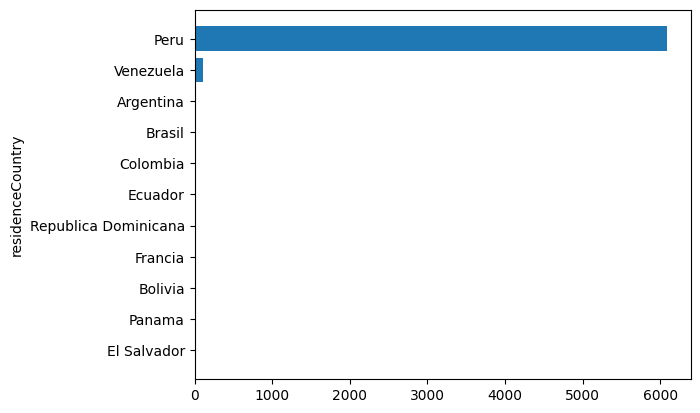

Canvia                                      86
Freelance (Clientes)                        78
Independiente                               42
Global Hitss                                40
Everis                                      39
Indra                                       38
Mdp Consulting                              37
Everis Peru Sac                             29
Tata Consultancy Services                   23
Tivit                                       21
Pontificia Universidad Catolica Del Peru    21
Experis                                     20
Autoridad Nacional Del Agua                 18
Banco De Credito Del Peru                   18
Softtek                                     17
Interbank                                   16
Freelance                                   16
Alicorp                                     15
Telefonica Del Peru                         15
Universidad Privada Del Norte               15
Name: lastWorkCenter, dtype: int64


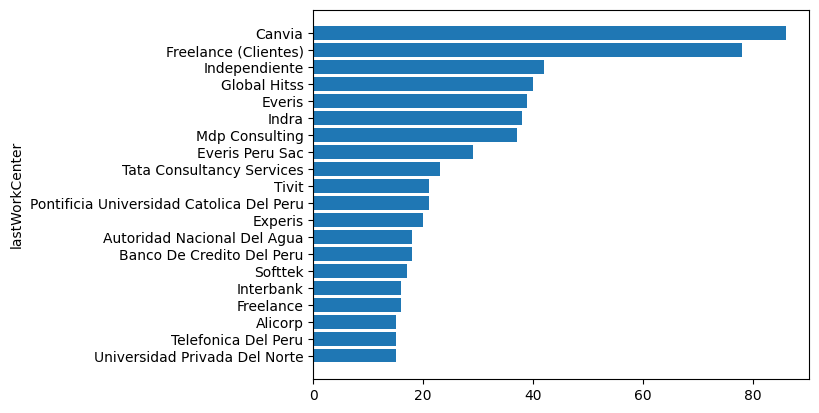

Analista Programador                            235
Analista De Sistemas                            118
Analista Funcional                               80
Supervisor De Infraestructura De Redes Cisco     78
Jefe De Proyectos                                61
Project Manager                                  52
Analista                                         39
Trabajadora Social                               35
Jefe De Sistemas                                 30
Asistente Administrativo                         28
Ejecutivo Comercial                              27
Data Engineer                                    26
Asistente De Sistemas                            26
Asistente De Recursos Humanos                    26
Practicante                                      26
Key Account Manager                              25
Analista Qa                                      25
Asesor Comercial                                 23
Analista Desarrollador                           23
Analista Pro

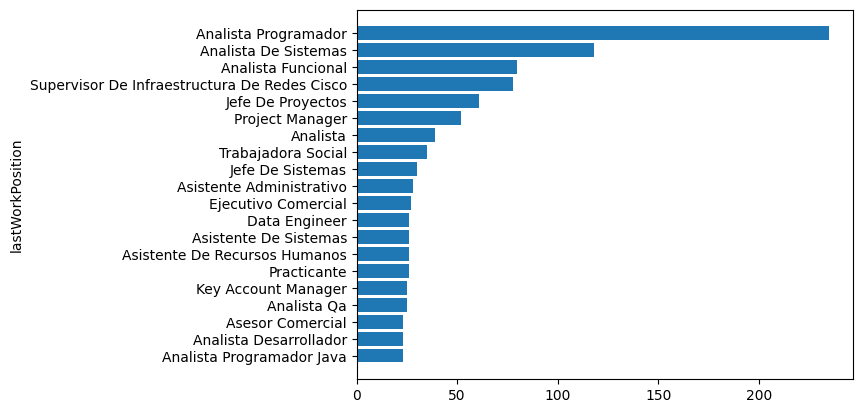

5     490
4     475
8     454
6     450
7     418
2     374
9     373
3     357
10    351
1     315
11    291
0     246
13    215
12    210
15    202
14    179
16    129
17     97
18     89
19     84
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


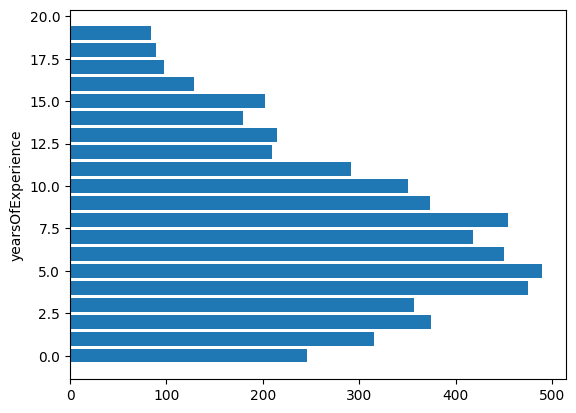

5     855
6     769
4     750
7     674
3     546
8     512
9     385
2     369
10    322
1     222
11    207
12    202
13    118
14    105
15     61
17     29
16     28
18     17
19     12
21      8
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


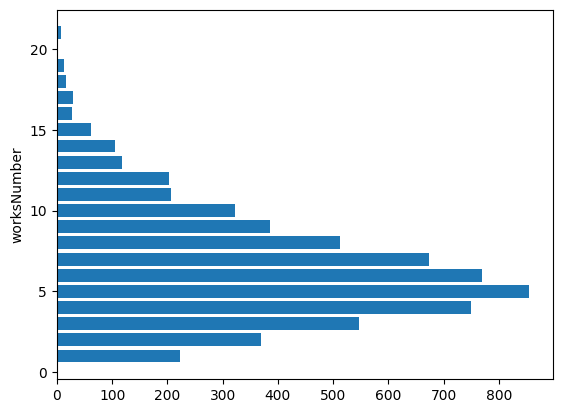

Universidad Peruana De Ciencias Aplicadas    347
Universidad Tecnologica Del Peru             215
Pontificia Universidad Catolica Del Peru     212
Universidad Nacional Mayor De San Marcos     176
Universidad Esan                             172
Universidad Privada Del Norte                147
Upc                                          137
Universidad Nacional De Ingenieria           132
Cibertec                                     129
Universidad Ricardo Palma                    124
Universidad De Lima                          116
Universidad Cesar Vallejo                    115
Instituto Cibertec                           111
Universidad Nacional Federico Villarreal     109
Universidad De San Martin De Porres          100
Isil                                          98
Universidad San Ignacio De Loyola             95
Universidad Inca Garcilaso De La Vega         90
Tecsup                                        89
Utp                                           84
Name: studyCenter, d

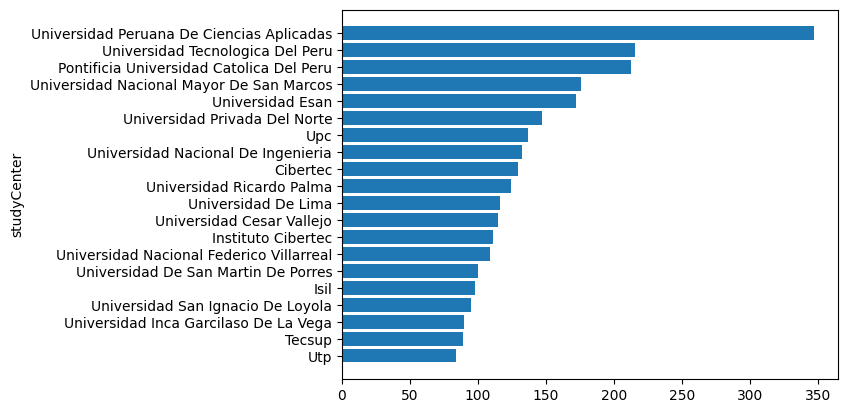

Ing. En Sistemas                  1450
Tecnologias De La Informacion      953
Adm. De Empresas                   645
Ing. Informatica                   373
Ing. Industrial                    308
Computacion / Informatica          263
Otra                               245
Marketing / Comercializacion       238
Recursos Humanos / Relac. Ind.     206
Ing. - Otros                       125
Psicologia                         114
Telecomunicaciones                  90
Ing. Telecomunicaciones             87
Analisis De Sistemas                84
Procesos / Calidad Total            78
Programacion                        74
Trabajo Social                      65
Finanzas                            64
Ing. Electronica                    58
Bachiller                           53
Name: careerField, dtype: int64


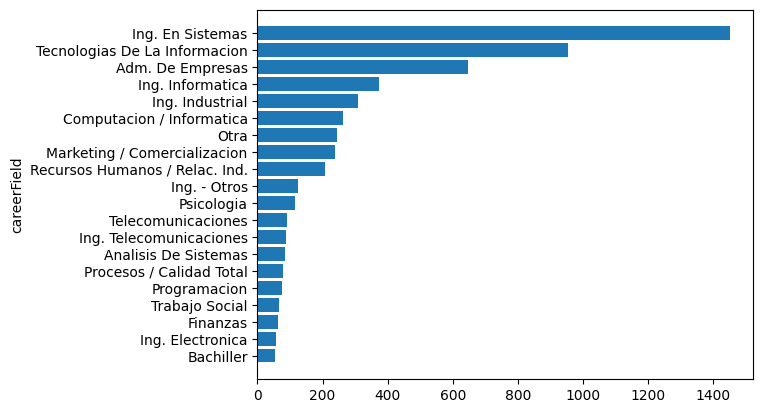

Graduado      4379
En Curso      1761
Abandonado      74
Name: careerStatus, dtype: int64


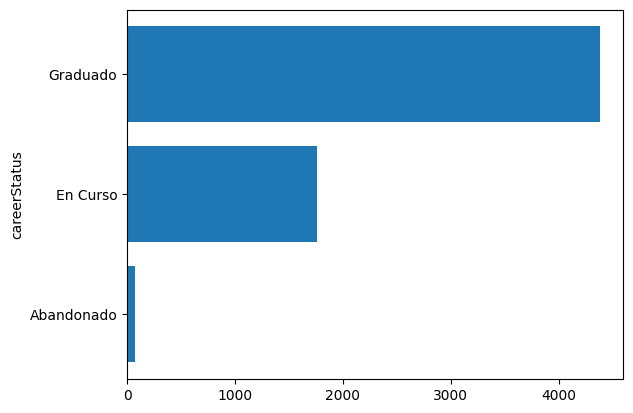

Universitario        2729
Otro                 1622
Posgrado              888
Terciario/Tecnico     509
Master                450
Doctorado              13
Secundario              3
Name: careerDegree, dtype: int64


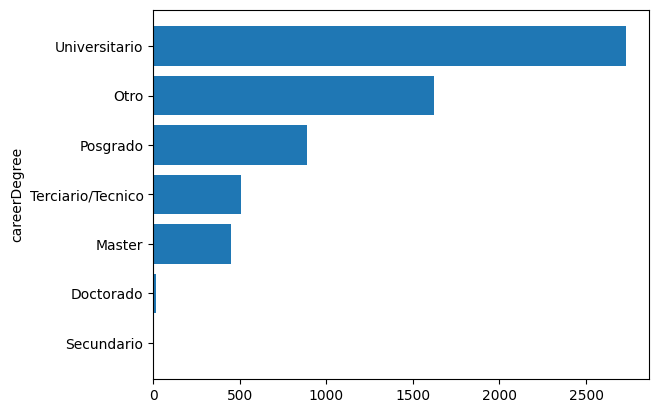

1     1858
2     1414
3      827
4      499
6      333
5      322
7      240
8      149
9      116
11      86
10      80
12      61
14      45
13      36
16      23
15      19
20      18
18      16
19      14
17      14
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


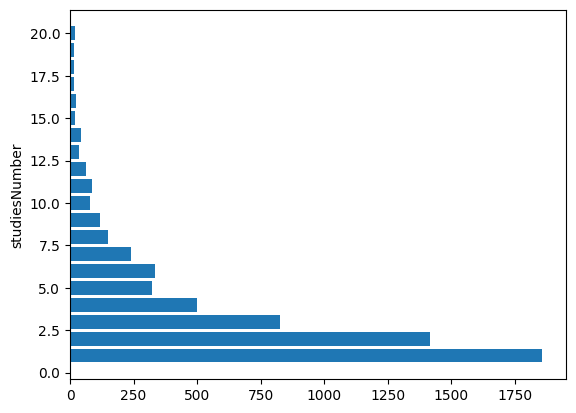

1     664
3     541
2     495
4     429
5     410
6     350
7     336
9     335
8     315
10    255
11    246
13    197
12    197
16    185
14    134
15    113
18     95
17     93
21     77
19     68
Name: technicalSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


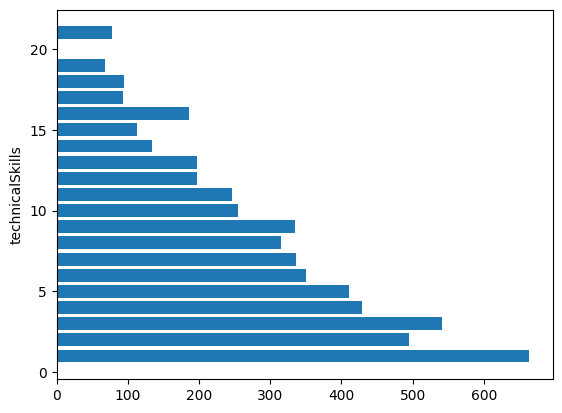

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


1    4654
2    1288
3     197
4      51
0      23
5       1
Name: languages, dtype: int64


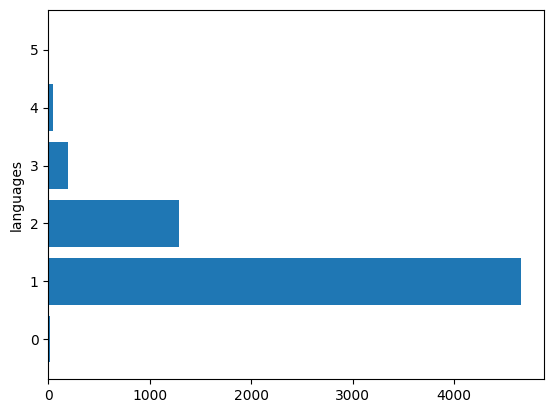

1     1288
2      902
3      650
4      593
5      536
6      405
7      353
8      291
9      223
10     182
11     147
12     117
13      93
14      69
15      64
17      42
16      35
20      31
19      25
23      22
Name: anotherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


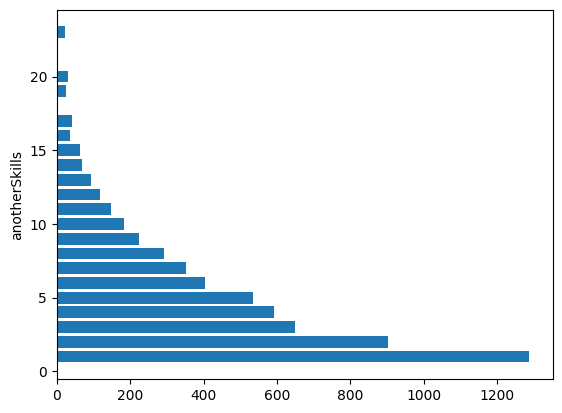

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


5000     413
2500     389
3500     381
3000     370
4000     369
2000     351
6000     347
4500     291
1500     247
1800     238
5500     220
6500     205
7000     200
1200     158
8000     154
1000     125
1        119
7500     110
10000    102
1025     101
Name: salary, dtype: int64


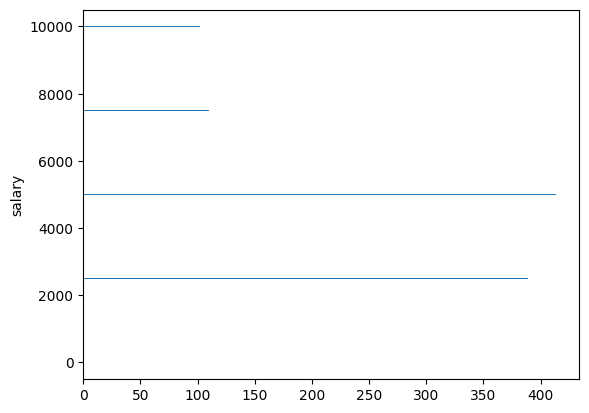

Fin: 2023-05-11 13:04:47.194629
Tiempo: 0:02:06.186752


In [208]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isLoadedLinkedin = True
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Leyendo o calculando linkedin
  linkedinData = readJson(os.path.join(intermFilesFolder, 'linkedin.json')) if isLoadedLinkedin else readAndWriteMain('linkedin')
  print("Se terminó de procesar Linkedin")

  # Uniendo la data principal (bumeran + linkedin)
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData, linkedinData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()